In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//')

import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

from src.models import thermal_model
from src.common import functions, enums, schema
from src.data import source


In [11]:
PATH_GB_DATA = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\00 - Final data\Annual_demand')
PATH_CIBSE_DATA = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\data\CIBSE weather data\WD16SET\WD16SET\WDD16SET\WDD16SET\WMD16SET\WMD16SET")

In [6]:
# Parameters 
path_results_simulation:Path = Path().absolute().parent/"data"/"results"
path_results_simulation.mkdir(parents=True, exist_ok=True)
target_year:int = 2022
solar_gains = True 
timestep:int = 3600 #seconds

HDD_ref_temperature:float = 15.5
CDD_ref_temperature:float = 24

path_export_netcdf_results:Path = Path().absolute().parent/"data"
path_thermal_data = PATH_GB_DATA/'Thermal_characteristics_afterEE.csv'
residential_data = pd.read_csv(path_thermal_data, index_col=0)
residential_data.head()

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC
Index,,,,,,,,,,,,
0,S01006506,aberdeen city,North East Scotland,detached,gas boiler,43906.250000,0.273266,102.0,17533.867465,175.625000,medium,-5.0
1,S01006506,aberdeen city,North East Scotland,detached,oil boiler,66000.000000,0.299051,12.0,19188.338395,264.000000,medium,-5.0
2,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,66187.500000,0.390676,1.0,25067.327542,264.750000,medium,-5.0
3,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,27846.153846,0.216864,60.0,13914.831788,111.384615,medium,-5.0
4,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,22055.555556,0.113292,2.0,7269.253731,88.222222,medium,-5.0


In [8]:
list_las = residential_data["Local Authority"].unique()
len(list_las)

380

In [5]:
# last_df = functions.create_dd_dataframes_for_all_LAs(list_las, path_export_netcdf_results, HDD_ref_temperature, CDD_ref_temperature)
# last_df

In [9]:

external_data = pd.read_csv(path_export_netcdf_results/"raw"/f"{LA_str}_degree_days.csv".replace(" ", "_"), index_col=0, parse_dates=True)
external_data.head()

,Solar_radiation_(W/m2),Temperature_(degreeC),hdd_15.5,cdd_24.0
Datetime_UTC,,,,
2010-01-01 00:00:00+00:00,0.0,-0.761292,0.677554,0.0
2010-01-01 01:00:00+00:00,0.0,-1.053894,0.689746,0.0
2010-01-01 02:00:00+00:00,0.0,-1.288513,0.699521,0.0
2010-01-01 03:00:00+00:00,0.0,-1.463013,0.706792,0.0
2010-01-01 04:00:00+00:00,0.0,-1.604095,0.712671,0.0


In [21]:
LA_str = "Cardiff"
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = Path(PATH_CIBSE_DATA).rglob('Cardiff_DSY2_2050High50*.csv')

list_files = []
for path in pathlist:
  print(path.stem)
  list_files.append(path.stem)
  temp_dataf = pd.read_csv(path, skiprows=32, header=None, delimiter=",", names=column_names)

Cardiff_DSY2_2050High50_


In [25]:
external_data = temp_dataf.rename(columns={'GSR':'Solar_radiation_(W/m2)', 'DBT': 'Temperature_(degreeC)'})
external_data.head()

,Year,Month,Day,Hour,PWC,Cloud,Temperature_(degreeC),WBT,RH,Press,...,Solar_radiation_(W/m2),DSR,Alt,Dec,Cloud1,DBT1,WBT1,Press1,WD1,WS1
0,2050,1,1,1,-999,6,9.5,8.6,89,994.0,...,0,0,-61.5,-23.0,0,0,0,0,0,0
1,2050,1,1,2,-999,4,9.5,8.6,89,994.9,...,0,0,-58.3,-23.0,0,0,0,0,0,0
2,2050,1,1,3,23,3,9.4,8.4,87,995.7,...,0,0,-51.8,-23.0,0,0,0,0,0,0
3,2050,1,1,4,-999,6,9.5,8.5,88,996.9,...,0,0,-43.5,-23.0,0,0,0,0,0,0
4,2050,1,1,5,81,7,9.5,8.5,88,997.5,...,0,0,-34.4,-23.0,0,0,0,0,0,0


In [32]:
for LA_str in ["Cardiff"]:#list_las[:1]:
    print(LA_str)
    # Load outdoor air temperature and solar radiation data for the local authority
    # external_data = pd.read_csv(path_export_netcdf_results/"raw"/f"{LA_str}_degree_days.csv".replace(" ", "_"), index_col=0, parse_dates=True)
    # external_data.fillna(0, inplace=True)
    filt = (residential_data["Local Authority"]==LA_str) & (residential_data["Thermal capacity level"]=="medium")
    LA_residential_data = residential_data.loc[filt, :]
    nb_dwellings = LA_residential_data["Number of dwellings"]
    temp_LA_results = LA_residential_data.apply(
                                        lambda row: functions.run_simulation(
                                        external_data, 
                                        row,
                                        target_year,
                                        solar_gains), axis=1, result_type="expand")
    temp_LA_results.columns = [schema.ResultSchema.SPECIFICHEATINGDEMAND, schema.ResultSchema.SPECIFICCOOLINGDEMAND]
    temp_LA_results[[schema.ResultSchema.HEATINGDEMAND, schema.ResultSchema.COOLINGDEMAND]] = temp_LA_results.mul(nb_dwellings, axis=0)
    temp_LA_results[schema.ResultSchema.YEAR] = target_year
    temp_LA_results.index.name = "Index"

Cardiff
heating demand 13178.28834253337kWh and cooling demand is -1480.5694957175774kWh
heating demand 1839.382857931384kWh and cooling demand is -1004.4780887229508kWh
heating demand 8465.611210356046kWh and cooling demand is -1068.0021960623067kWh
heating demand 3909.278354695921kWh and cooling demand is -693.5862658182167kWh
heating demand 11849.738946043448kWh and cooling demand is -1039.6179084709079kWh
heating demand 3045.476219551525kWh and cooling demand is -628.5024810440653kWh
heating demand 9292.816996610829kWh and cooling demand is -1099.063956427597kWh
heating demand 6560.381992730259kWh and cooling demand is -528.9309870453701kWh
heating demand 1383.922115248056kWh and cooling demand is -518.8298068697582kWh
heating demand 9009.594844031624kWh and cooling demand is -819.7164574424289kWh
heating demand 13178.28834253337kWh and cooling demand is -1480.5694957175774kWh
heating demand 6669.38701548102kWh and cooling demand is -718.4985959629948kWh
heating demand 3909.2783546

In [33]:
temp_concat_results = pd.concat([LA_residential_data, temp_LA_results], axis=1)
temp_concat_results.head()

,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Design temperature degreeC,Region,LSOA_code,Local Authority,Specific heating demand (kWh/dwelling),Specific cooling demand (kWh/dwelling),Heating demand (kWh),Cooling demand (kWh),Year
Index,,,,,,,,,,,,,,,,,
689055,detached,gas boiler,33093.997112,0.396883,23.0,19611.409381,132.375988,medium,-3.0,Wales,W01001694,Cardiff,13178.288343,-1480.569496,3.031006e+05,-34053.098402,2022
689056,detached,resistance heating,22026.609504,0.096644,5.0,4775.532443,88.106438,medium,-3.0,Wales,W01001694,Cardiff,1839.382858,-1004.478089,9.196914e+03,-5022.390444,2022
689057,semi-detached,gas boiler,23154.761905,0.260537,44.0,12874.074074,92.619048,medium,-3.0,Wales,W01001694,Cardiff,8465.611210,-1068.002196,3.724869e+05,-46992.096627,2022
689058,semi-detached,resistance heating,13957.389286,0.129795,3.0,6413.651623,55.829557,medium,-3.0,Wales,W01001694,Cardiff,3909.278355,-693.586266,1.172784e+04,-2080.758797,2022
689059,terraced,gas boiler,24820.312500,0.342285,446.0,16913.555556,99.281250,medium,-3.0,Wales,W01001694,Cardiff,11849.738946,-1039.617908,5.284984e+06,-463669.587178,2022


In [34]:
cooling_per_m2 = schema.ResultSchema.SPECIFICCOOLINGDEMAND.replace("kWh/dwelling", "kWh/m2")
temp_concat_results[cooling_per_m2] = temp_concat_results[schema.ResultSchema.SPECIFICCOOLINGDEMAND]/temp_concat_results["Average floor area m2"]
temp_concat_results[cooling_per_m2]

Index
689055   -11.184577
689056   -11.400734
689057   -11.531129
689058   -12.423281
689059   -10.471443
            ...    
691281   -12.967511
691282    -9.657034
691283   -12.916995
691284   -11.313307
691285    -8.470383
Name: Specific cooling demand (kWh/m2), Length: 1737, dtype: float64

In [35]:
nb_dwellings = temp_concat_results["Number of dwellings"].sum()
total_floor_area = temp_concat_results["Average floor area m2"].sum()*nb_dwellings
print(f"In {LA_str}, there are {nb_dwellings:,.0f} dwellings for a total floor area of {total_floor_area/1_000_000:,.0f} km2")

In Cardiff, there are 144,220 dwellings for a total floor area of 22,281 km2


<AxesSubplot: xlabel='Dwelling forms'>

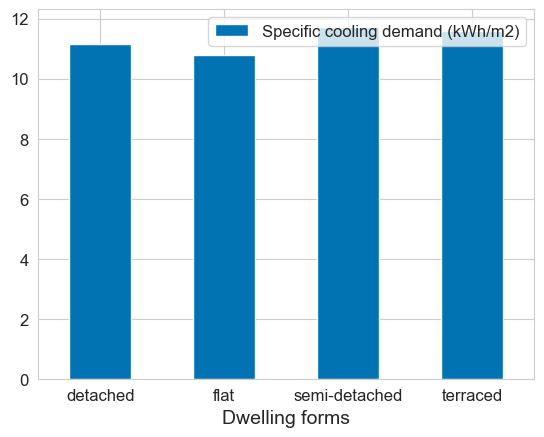

In [36]:
(-temp_concat_results.groupby("Dwelling forms").agg({cooling_per_m2:"mean"})).plot.bar(rot=0)


<AxesSubplot: xlabel='Dwelling forms'>

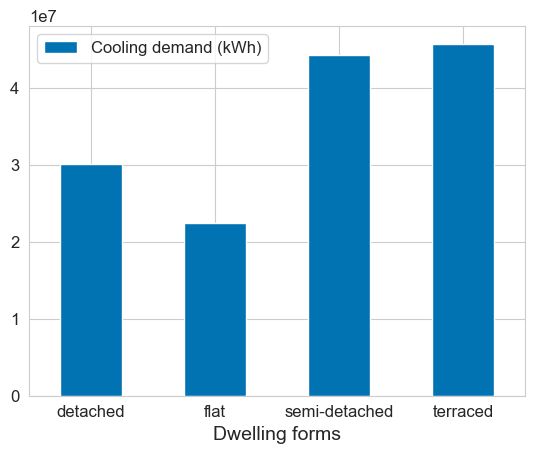

In [37]:
(-temp_concat_results.groupby("Dwelling forms").agg({schema.ResultSchema.COOLINGDEMAND:"sum"})).plot.bar(rot=0)

<AxesSubplot: xlabel='Dwelling forms'>

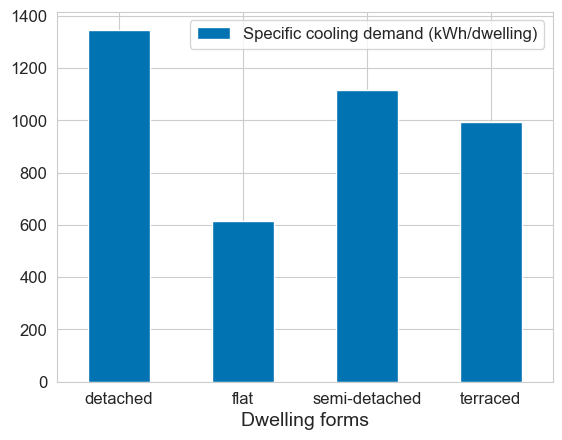

In [38]:
(-temp_concat_results.groupby("Dwelling forms").agg({schema.ResultSchema.SPECIFICCOOLINGDEMAND:"mean"})).plot.bar(rot=0)

In [39]:
temp_LA_results[schema.ResultSchema.COOLINGDEMAND].sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of Index
689055    -34053.098402
689056     -5022.390444
689057    -46992.096627
689058     -2080.758797
689059   -463669.587178
              ...      
691281     -1061.645991
691282    -43413.194260
691283      -907.343061
691284    -64664.781183
691285    -40761.178300
Name: Cooling demand (kWh), Length: 1737, dtype: float64>